# Proving that Greater Metro Sydney was a Coronavirus Hotspot via Binomial Regression and Bayesian inference of NSW Covid test data

This notebook explores the NSW Covid 19 test data to look for patterns ... blah blah

URL: https://data.nsw.gov.au/data/dataset/5424aa3b-550d-4637-ae50-7f458ce327f4/resource/227f6b65-025c-482c-9f22-a25cf1b8594f/download/covid-19-tests-by-date-and-location-and-result.csv

The data are categorised by date and postcode, local health district, local government area, and result. Updated daily. Fetched on Thu 15 Oct 2020 at 5:00pm.

A surge on a given day does not indicate a surge in tests for that day. Test data are updated in batches after a weekend as normal work hours commence, and also as laboratories gain new testing capacity.

The NSW government provides assurances that the data are anonymised and no single person can be identified from the dataset.

## Understanding NSW districts

![image of nsw regional districts](files/nsw.jpg)

The above shows all the regional districts of NSW as they appear in a geographic space.

![image of nsw metro districts](files/metro.jpg)

The above shows the Metropolitan districts of NSW.

What we learn from this is that places like South Eastern Sydney, Sydney, and Northern Sydney are the closest to the airport, whereas regional NSW is far away from population centres.

According to https://profile.id.com.au the following is true about regional vs. metro NSW:

- The 2019 Estimated Resident Population for Regional NSW is 2,777,654, with a population density of 0.04 persons per hectare.
- The 2019 Estimated Resident Population for Greater Sydney is 5,312,163, with a population density of 4.29 persons per hectare.

Woah, that's a pretty big difference!

We hypothesise that given metro NSW has a higher population density, and its closeness to the airport, there will be a higher positive test rate when compared to regional NSW. We don't know whether positive test rate is directly related to population density, so we do not expect a 100-fold difference exactly.

In order to prove this, we will compare Far West NSW, the Nepean Blue Mountains, and South Eastern Sydney. We'll first assess the binomial distribution to validate positive test cases, and then we'll use naive Bayes algorithms to determine which region a positive test will most likely originate from.

First, it's time to load in our data.

In [1]:
# load the relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import binom
import matplotlib.pyplot as plt
from statistics import median
from math import factorial
from statistics import mean
def n_choose_m(n, m):
    return factorial(n)/(factorial(n-m)*factorial(m))

In [2]:
# load in the dataset
# make relevant adjustments to the datatype after inspecting in excel
df = pd.read_csv(
    'covid-19-tests-by-date-and-location-and-result.csv',
    #dtype={'postcode': 'Int64', 'lga_code19': 'Int64'},
    parse_dates=['test_date']
)
df[['postcode', 'lga_code19']] = df[['postcode', 'lga_code19']].fillna(0)
df[['postcode', 'lga_code19']] = df[['postcode', 'lga_code19']].apply(pd.to_numeric, downcast='integer')

print(set(df.lhd_2010_name))

{nan, 'South Eastern Sydney', 'Southern NSW', 'South Western Sydney', 'Murrumbidgee', 'Hunter New England', 'Western NSW', 'Sydney', 'Nepean Blue Mountains', 'Illawarra Shoalhaven', 'Central Coast', 'Far West', 'Mid North Coast', 'Western Sydney', 'Northern Sydney', 'Network with Vic', 'Northern NSW'}


In [3]:
df['region'] = df.lhd_2010_name.fillna('').apply(lambda x: 'regional' if x in [
    'Murrumbidgee', 'Far West', 'Western NSW', 'Hunter New England',
    'Northern NSW', 'Mid North Coast', 'Illawarra Shoalhaven', 'Southern NSW',
    'Network with Vic'
] else 'metro' if x != '' else np.nan)

In [4]:
# inspect the data visually
df.head()

,test_date,postcode,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19,result,region
0,2020-01-01,2039,X700,Sydney,14170,Inner West (A),Tested & excluded,metro
1,2020-01-01,2040,X700,Sydney,14170,Inner West (A),Tested & excluded,metro
2,2020-01-01,2069,X760,Northern Sydney,14500,Ku-ring-gai (A),Tested & excluded,metro
3,2020-01-01,2110,X760,Northern Sydney,14100,Hunters Hill (A),Tested & excluded,metro
4,2020-01-01,2190,X710,South Western Sydney,11570,Canterbury-Bankstown (A),Tested & excluded,metro


In [5]:
df.tail()

,test_date,postcode,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19,result,region
539045,2020-06-08,0,NaN,NaN,0,NaN,Tested & excluded,NaN
539046,2020-06-08,0,NaN,NaN,0,NaN,Tested & excluded,NaN
539047,2020-06-08,0,NaN,NaN,0,NaN,Tested & excluded,NaN
539048,2020-06-08,0,NaN,NaN,0,NaN,Tested & excluded,NaN
539049,2020-06-08,0,NaN,NaN,0,NaN,Tested & excluded,NaN


The data appear normal, but it looks like there are sections where the data are completely anonymised. In this case we will assign a new flag in a new column: `anon`.

Note that anonymised data are not people choosing to remain anonymous; rather this is a technique known as differential privacy.

In [6]:
df['anon'] = np.where(df.postcode == 0, True, False)

In [7]:
df.head()

,test_date,postcode,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19,result,region,anon
0,2020-01-01,2039,X700,Sydney,14170,Inner West (A),Tested & excluded,metro,False
1,2020-01-01,2040,X700,Sydney,14170,Inner West (A),Tested & excluded,metro,False
2,2020-01-01,2069,X760,Northern Sydney,14500,Ku-ring-gai (A),Tested & excluded,metro,False
3,2020-01-01,2110,X760,Northern Sydney,14100,Hunters Hill (A),Tested & excluded,metro,False
4,2020-01-01,2190,X710,South Western Sydney,11570,Canterbury-Bankstown (A),Tested & excluded,metro,False


In [8]:
df.tail()

,test_date,postcode,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19,result,region,anon
539045,2020-06-08,0,NaN,NaN,0,NaN,Tested & excluded,NaN,True
539046,2020-06-08,0,NaN,NaN,0,NaN,Tested & excluded,NaN,True
539047,2020-06-08,0,NaN,NaN,0,NaN,Tested & excluded,NaN,True
539048,2020-06-08,0,NaN,NaN,0,NaN,Tested & excluded,NaN,True
539049,2020-06-08,0,NaN,NaN,0,NaN,Tested & excluded,NaN,True


## The binomial distribution

Current knowledge is that Melbourne and Sydney have had the most positive confirmed cases. We will find the probability of whether a person is likely to test positive based on the region in which they live in NSW, then use the binomial distribution to determine the likelihood that probability is indicative of the realworld; i.e. true.

We do this because we need to ensure that the testing methodology is accurate before we can make any inferences from Bayes' theorem.

In [9]:
df.groupby('lhd_2010_name')['result'].value_counts()

lhd_2010_name          result           
Central Coast          Tested & excluded    23596
                       Case - Confirmed       117
Far West               Tested & excluded     1386
                       Case - Confirmed         2
Hunter New England     Tested & excluded    68244
                       Case - Confirmed       279
Illawarra Shoalhaven   Tested & excluded    24463
                       Case - Confirmed       115
Mid North Coast        Tested & excluded    11016
                       Case - Confirmed        50
Murrumbidgee           Tested & excluded    10300
                       Case - Confirmed        38
Nepean Blue Mountains  Tested & excluded    31901
                       Case - Confirmed       178
Network with Vic       Tested & excluded     1707
                       Case - Confirmed         8
Northern NSW           Tested & excluded    16302
                       Case - Confirmed        55
Northern Sydney        Tested & excluded    67830
         

In [10]:
df.groupby('region')['result'].value_counts()

region    result           
metro     Tested & excluded    356298
          Case - Confirmed       2326
regional  Tested & excluded    155971
          Case - Confirmed        647
Name: result, dtype: int64

This gives us an idea of the values to expect, but we're interested in the probability. 

In any case, the probability is the total positive results divided by total tests, for each region. We wish to know how likely it is that the following probabilities are true.

We'll compute this for our three selected sample regions, and then the aggregate regions (metro & regional).

In [11]:
probs = df.result.eq('Case - Confirmed').groupby(df['lhd_2010_name']).mean()
print(probs)

lhd_2010_name
Central Coast            0.004934
Far West                 0.001441
Hunter New England       0.004072
Illawarra Shoalhaven     0.004679
Mid North Coast          0.004518
Murrumbidgee             0.003676
Nepean Blue Mountains    0.005549
Network with Vic         0.004665
Northern NSW             0.003362
Northern Sydney          0.007840
South Eastern Sydney     0.009429
South Western Sydney     0.004746
Southern NSW             0.005593
Sydney                   0.004726
Western NSW              0.003510
Western Sydney           0.005526
Name: result, dtype: float64


In [12]:
probs = df.result.eq('Case - Confirmed').groupby(df['region']).mean()
print(probs)

region
metro       0.006486
regional    0.004131
Name: result, dtype: float64


We have now ascertained the probability that you will test positive in NSW based on the region that you test in. 

Eyeballing it, if you tested in South Eastern Sydney, you were most likely to test positive, but if you tested in Far West you were least likely to test positive. Hypothetically, this is an indication that the virus, at least as of today, has not penetrated the Far West of NSW as much as other regions *or* that the Far West of NSW has suboptimal conditions for viral spread.

For each region, we assert that `n` is the total number of tests, and `p` is the probability of success in each trial. We are interested in finding the value of `n`, given `k` positive outcomes, for each region.

What can we say about the probability of these probabilities?

Let's first take Far West, where `n` is equal to `1388` and `p` is equal to `2/1388`, or `0.001441`. Let's substitute these into our binomial function and see what it looks like.

Text(0, 0.5, 'Probability Density')

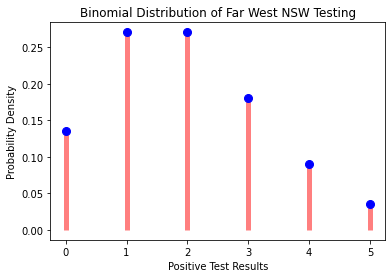

In [32]:
fig, ax = plt.subplots(1,1)
n, p = 1388, 0.001441
mean, var, skew, kurt = binom.stats(n, p, moments='mvsk')
x = np.arange(
    binom.ppf(0.01, n, p),
    binom.ppf(0.99, n, p))
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf for far west')
ax.vlines(x, 0, binom.pmf(x, n, p), colors='r', lw=5, alpha=.5)
plt.title('Binomial Distribution of Far West NSW Testing')
plt.xlabel('Positive Test Results')
plt.ylabel('Probability Density')

We do not have a lot of data points, but what we see is that we should expect 1 or 2 out of our total sample to test positive, which lines up with our empirical data.

Let's run a quick `np.allclose` check to see if we are accurate. This function checks to see that the cumulative density function is equal to the percentage point function in element-wise order. Essentially: we construct a confidence interval and assert that it is satisfactory. If satisfactory, assert that the result is accurate.

In [15]:
prob = binom.cdf(x, n, p)
np.allclose(x, binom.ppf(prob, n, p))

True

In [16]:
print('median:', median(x))
print('discrete probability:', max(binom.pmf(x, n, p)))

median: 2.5
discrete probability: 0.2708657608253548


Success! There is a 27% chance that 2.5 people will test positive, which is very close to our real world results of 2 positive tests.

We'll use a mathematical prove just to demonstrate that the function above is doing what we expect.

Recall the binomial function:

\begin{equation*}
P(E)   = {n \choose k} p^k (1-p)^{ n-k}
\end{equation*}

Substituting in our values:

\begin{equation*}
P(E)   = {1388 \choose 2} 0.001441^2 (1-0.001441)^{ 1388-2}
\end{equation*}

Thus manually calculating this results in:

\begin{equation*}
P(E)   = 962578 \cdot 2.076481e^{-06} \times 0.1355158 = 0.27086
\end{equation*}

Let's check for South Eastern Sydney, which we know has a much larger dataset...

Text(0, 0.5, 'Probability Density')

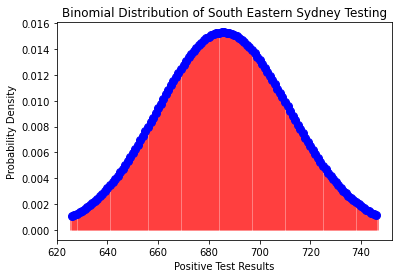

In [31]:
fig, ax = plt.subplots(1,1)
n, p = 72758, 0.009429
mean, var, skew, kurt = binom.stats(n, p, moments='mvsk')
x = np.arange(
    binom.ppf(0.01, n, p),
    binom.ppf(0.99, n, p))
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf for far west')
ax.vlines(x, 0, binom.pmf(x, n, p), colors='r', lw=5, alpha=.5)
# Add title and axis names
plt.title('Binomial Distribution of South Eastern Sydney Testing')
plt.xlabel('Positive Test Results')
plt.ylabel('Probability Density')


In [18]:
prob = binom.cdf(x, n, p)
np.allclose(x, binom.ppf(prob, n, p))

True

In [19]:
print('median:', median(x))
print('discrete probability:', max(binom.pmf(x, n, p)))

median: 686.0
discrete probability: 0.015302131865897095


Also success! And we get a much prettier graph.

We know that 686 positive tests were recorded in the real world for GES, so this is promising. Though the probability is smaller, since there is a much larger number of tests.

Still, we can be confident this is accurate.

Last, let's check for the Nepean Blue Mountains.

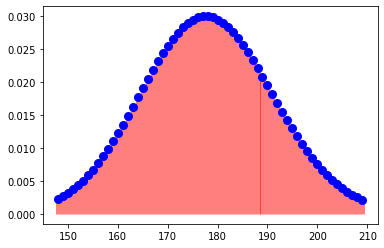

In [20]:
fig, ax = plt.subplots(1,1)
n, p = 31901+178, 0.005549
mean, var, skew, kurt = binom.stats(n, p, moments='mvsk')
x = np.arange(
    binom.ppf(0.01, n, p),
    binom.ppf(0.99, n, p))
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf for far west')
ax.vlines(x, 0, binom.pmf(x, n, p), colors='r', lw=5, alpha=.5)
plt.title('Binomial Distribution of Nepean Blue Mountains Testing')
plt.xlabel('Positive Test Results')
plt.ylabel('Probability Density')

In [21]:
prob = binom.cdf(x, n, p)
np.allclose(x, binom.ppf(prob, n, p))

True

In [22]:
print('median:', median(x))
print('discrete probability:', max(binom.pmf(x, n, p)))

median: 178.5
discrete probability: 0.029971256440867854


Yahoo! Regardless of whether the contact tracing program is good or not, we can assert from this result that the testing program works as we would expect. The median here is 178.5 (and we had 178 in the real world) and the probability is pretty much 3%, which is the highest of the distribution.

## Simulating the binomial distribution

Just to close this section, instead of a mathematical proof, let's simulate for the Far West region. We expect a median of 2 with a probability of... you guessed it, 27%.

We would simulate for Nepean Blue Mountains but we don't have capable computer hardware to do it in a reasonable amount of time.

And since we have a much smaller set of tests we can simulate many, many more times.

In [23]:
result = []
for i in range(750000):
    test = np.random.choice([True, False], 1388, p=[.001441, 1-.001441])
    result.append(np.sum(test))
test = pd.DataFrame(result, columns=['positives'])
grouped = test.groupby('positives')['positives'].value_counts()
grouped

positives  positives
0          0            101130
1          1            202425
2          2            203336
3          3            135612
4          4             67837
5          5             27342
6          6              8951
7          7              2557
8          8               625
9          9               152
10         10               32
11         11                1
Name: positives, dtype: int64

Looks good so far! Now let's get the means...

In [24]:
grouped / grouped.sum() * 100

positives  positives
0          0            13.484000
1          1            26.990000
2          2            27.111467
3          3            18.081600
4          4             9.044933
5          5             3.645600
6          6             1.193467
7          7             0.340933
8          8             0.083333
9          9             0.020267
10         10            0.004267
11         11            0.000133
Name: positives, dtype: float64

It's pretty dang close! Interesting enough, the probability that you'll get 13 positive tests in Far West NSW is practically 0!

Let's plot this like we did before, by computing the binomial distribution, just to check it out.

## Inference via Naive Bayesian theory

Bayes' theorem states that the probability of A being true, given B, is the function of the probability of B given A by the probability of A, divided by the probability of B. 

Recall Bayes' theorem:

\begin{equation*}
P(A|B) = \frac{{P(B|A)}.{P(A)}}{P(B)}
\end{equation*}

We wish to find the probability that a person is from regional NSW (A) given that they have tested positive for the coronavirus (B). We will compute the probability that a person tests positive (B), being in NSW, and subtract this from 1 to find the probability the person who tested positive is from regional NSW.

Naive Bayes stipulates that all possible explanatory variables (Bs) are independent of each other. We will work solely on the assumption that our B is independent of all other explanatory variables.

Essentially what we want to predict is whether a given positive test case comes from Regional or Metro NSW. Substituting into Bayes theorem:

\begin{equation*}
P(metro|pos) = \frac{{P(pos|metro)}.{P(pos\_metro \times metro)}}{P(pos\_non\_metro \times non\_metro) + P(pos\_metro \times metro)}
\end{equation*}

and

\begin{equation*}
P(regional|pos) = 1 - P(metro|pos)
\end{equation*}

First, we need to know the global positive test rate for the general population of NSW.

In [25]:
df.groupby('result')['result'].value_counts()

result             result           
Case - Confirmed   Case - Confirmed       3117
Tested & excluded  Tested & excluded    535933
Name: result, dtype: int64

In [26]:
df.groupby('region')['result'].value_counts()

region    result           
metro     Tested & excluded    356298
          Case - Confirmed       2326
regional  Tested & excluded    155971
          Case - Confirmed        647
Name: result, dtype: int64

In [27]:
pos_rate = 3117/535933
print('Positive test rate:', pos_rate)
neg_rate = 1-pos_rate
print('Negative test rate:', neg_rate)
p_non_metro = 2777654/(5312163+2777654)
print('Probability lives in regional NSW:', p_non_metro)
p_metro = 1-p_non_metro
print('Probability lives in metro NSW:', p_metro)
p_pos_non_metro = 647/155971
print('Positive test rate regional NSW', p_pos_non_metro)
p_pos_metro = 2326/356298
print('Positive test rate metro NSW', p_pos_metro)
p_neg_metro = 1-p_pos_metro
print('Negative test rate metro NSW', p_neg_metro)

Positive test rate: 0.005816025510651518
Negative test rate: 0.9941839744893485
Probability lives in regional NSW: 0.3433518953518973
Probability lives in metro NSW: 0.6566481046481027
Positive test rate regional NSW 0.004148207038487924
Positive test rate metro NSW 0.006528243212142645
Negative test rate metro NSW 0.9934717567878574


In [28]:
numerator = p_pos_metro * p_metro
denominator = p_pos_metro * p_metro + p_pos_non_metro * p_non_metro
probability = numerator / denominator

probability > pos_rate

True

In [29]:
print(numerator, denominator, probability)

0.00428675853193531 0.0057110532809122195 0.7506073435285113


In [30]:
print(1-probability)

0.24939265647148867


## Conclusions

What we have learned is that when you test positive for Coronavirus in NSW, there is a 75% chance you live in metropolitan NSW and a 25% chance you live in regional NSW.

So if you are going on an interstate holiday to NSW this year, ensure you only visit regional areas!